In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[
    (GoodSubs['FD_exclusion']<=2)&(
        GoodSubs['ABS_exclusion']<=1)&(
        GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)

HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
subs['MB'] =  [int(re.search('mb(.*)me',str(x)).group(1)) for x in subs['acq']]
subs['ME'] =  [int(re.search('me(.*)',str(x)).group(1)) for x in subs['acq']]

print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                          len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))
  

We collected and downloaded data from 43 subjects
 There are 32 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 13 with a 20 channel headcoil


# Count Subjects with full L1 output

In [3]:
act=[]
ppi=[]
L2ppi=[]
for index,row in subs.iterrows():
    sub=row['sub']
    acq=row['acq']
    act.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    L2ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L2_task-sharedreward_model-1_type-ppi_seed-VS_thr5_sm-4.gfeat/cope10.feat/stats/cope1.nii.gz'%(sub)))

subs['L1act']=act
subs['L1ppi']=ppi
subs['L2ppi']=L2ppi
#display(subs)
subs[subs['L2ppi']==False].head()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi
102,249,sub-10185,mb6me1,2,0.777281,0.109853,False,False,False,HeadNeck_20,6,1,True,True,False
103,248,sub-10185,mb1me4,0,0.445697,0.061965,False,False,False,HeadNeck_20,1,4,True,True,False
104,247,sub-10185,mb6me4,2,0.474361,0.077345,False,False,False,HeadNeck_20,6,4,False,False,False
105,246,sub-10185,mb3me1,0,1.528850,0.128609,False,True,False,HeadNeck_20,3,1,True,True,False
106,245,sub-10185,mb3me4,1,0.624076,0.079947,False,False,False,HeadNeck_20,3,4,True,True,False


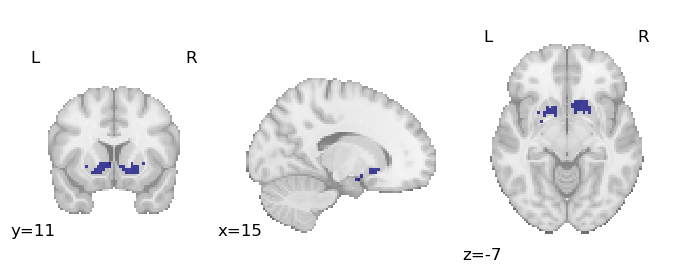

In [4]:
r_vs='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
l_vs='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
F_VS=math_img('img1+img2',img1=r_vs,img2=l_vs)
plotting.plot_roi(F_VS,draw_cross=False)
plt.savefig("../derivatives/figures/assets/mask_VS-func.svg")
plt.show()

NameError: name 'mask_name' is not defined

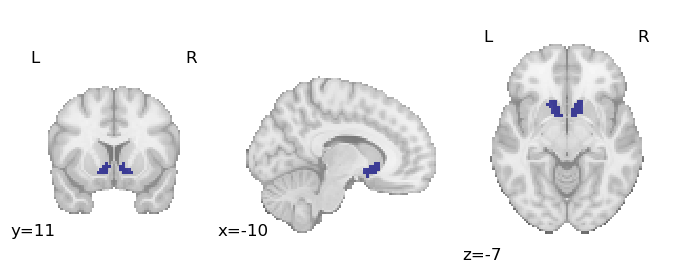

In [5]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        #mask_name=re.search('ROI-(.*)_cname',mask).group(1)
        #print(mask_name)
        plotting.plot_roi(mask,draw_cross=False)
        plt.savefig("../derivatives/figures/assets/mask_%s.svg"%(mask_name))
        plt.show()
mask_list=[F_VS,VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]


# VS- Reward Activiation

In [ ]:
#masker= NiftiMasker(mask_img=VS_mask)
masker= NiftiMasker(mask_img=F_VS)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(VS_Reward_cope=copes,
               VS_Reward_zstats=zstats,
               VS_Reward_varcope=varcopes)

# Display Reward Activation by Acquisition

In [ ]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('VS_Reward_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('VS_Reward_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('VS_Reward_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())

sns.catplot(x='MB',y='VS_Reward_zstats',hue='ME',data=plt_df,kind='bar',ci=68,
            order=[1,3,6],col='HeadCoil')

plt.savefig("../derivatives/figures/assets/Reward_VS-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('VS_Reward_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/assets/Reward_VS-act_cope.svg")

plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.savefig("../derivatives/figures/assets/Reward_VS-act_varcope.svg")
#plt.show()

In [ ]:
display(plt_df)
sns.lmplot(x='Max_Abs_motion',y='VS_Reward_cope',data=plt_df)

# FFA-Face Activiation

In [ ]:
masker= NiftiMasker(mask_img=FFA_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope11.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope11.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_face_cope=copes,
               FFA_face_zstats=zstats,
               FFA_face_varcope=varcopes)

# Display Face Activation by Acquisition (FFA)

In [ ]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('FFA_face_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('FFA_face_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('FFA_face_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('FFA_face_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('FFA_face_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='FFA_face_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_varcope.svg")


# Central Gyrus-Button Activiation

In [ ]:
masker= NiftiMasker(mask_img=motor_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_zstats=zstats,
               Motor_LR_varcope=varcopes)

# Display Motor Activation by Acquisition

In [ ]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('Motor_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('Motor_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('Motor_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/Motor_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',ci=68
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/Motor_LR-act_cope.svg")
plt.show()


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/Motor_LR-act_varcope.svg")
#plt.show()

# Central ICerbt-Button Activiation

In [ ]:
masker= NiftiMasker(mask_img=iCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_LR_cope=copes,
               iCerb_LR_zstats=zstats,
               iCerb_LR_varcope=varcopes)

# Display Inferior Cerebellar Activation by Acquisition

In [ ]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('iCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('iCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('iCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='iCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_varcope.svg")
plt.show()

# SCerb-Button Activiation

In [ ]:
masker= NiftiMasker(mask_img=sCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(SCerb_LR_cope=copes,
               SCerb_LR_zstats=zstats,
               SCerb_LR_varcope=varcopes)

# Display Superior Cerebellar Activation by Acquisition

In [ ]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('SCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('SCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('SCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='SCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_varcope.svg")
plt.show()

# vmPFC

In [ ]:
masker= NiftiMasker(mask_img=pfc_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope15.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/tstat15.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope15.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(pfc_act_cope=copes,
               pfc_act_zstats=zstats,
               pfc_act_varcope=varcopes)

# Display vmPFC

In [ ]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('pfc_act_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('pfc_act_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('pfc_act_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('pfc_act_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('pfc_act_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='pfc_act_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_varcope.svg")